In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
import warnings
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import  precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load`.*")
    
# --- Project structure ---
BASE_DIR = Path.cwd()
PROJECT_DIR = BASE_DIR.parent
DATASET_DIR = PROJECT_DIR / "dataset"
MODEL_BASE_DIR = PROJECT_DIR / "Models"
# --- Dataset paths ---
CALIB_NORMAL_FULL_PATH = DATASET_DIR / "SWaT_Dataset_Normal_v0.csv"
ATTACK_PATH            = DATASET_DIR / "Attack_v0_first_attack.csv"

In [2]:
# --- Select configuration ---
HIDDEN_SIZE = 16
SEQUENCE_LENGTH = 10
MODEL_NAME       = "LSTM_SWaT"
MODEL_VERSION    = "v1"
BEST_EPOCH = "best"  # or e.g. 16 for manual selection

# --- Evaluation settings ---
ENABLE_EVAL_SAVE = True
DEVICE                   = "cpu"
LABEL_COL                = "Normal/Attack"
USE_PERCENTILE_THRESHOLD = True
THRESHOLD_PERCENTILE     = 92
PRED_THRESHOLD           = 0.001193  # only used if USE_PERCENTILE_THRESHOLD == False
NUM_LAYERS       = 1
NUM_FEATURES     = 40



# --- Predefined best epochs for combinations of (HIDDEN_SIZE, SEQUENCE_LENGTH) ---
BEST_EPOCHS = {
    (8, 10): 16,
    (16, 10): 29,
    (32, 10): 25,
    (8, 50): 3,
    (16, 50): 24,
    (32, 50): 43,
    (8, 100): 22,
    (16, 100): 4,
    (32, 100): 12,
}

# --- Dynamic model directory ---
MODEL_DIR = PROJECT_DIR / "Models" / f"HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}"
if not MODEL_DIR.exists():
    print(f"[ERROR] MODEL_DIR does not exist:\n  {MODEL_DIR}")
    raise FileNotFoundError("Model directory not found.")

# --- Resolve BEST_EPOCH (table-based, not max epoch) ---
if BEST_EPOCH in ("best", True):
    key = (HIDDEN_SIZE, SEQUENCE_LENGTH)
    if key not in BEST_EPOCHS:
        print(f"[ERROR] No predefined best epoch for: HS{HIDDEN_SIZE}, IW{SEQUENCE_LENGTH}")
        raise KeyError("Missing BEST_EPOCHS entry for this (HIDDEN_SIZE, SEQUENCE_LENGTH).")
    BEST_EPOCH = BEST_EPOCHS[key]
    print(f"[INFO] Using predefined best epoch: {BEST_EPOCH} (HS{HIDDEN_SIZE}, IW{SEQUENCE_LENGTH})")
else:
    BEST_EPOCH = int(BEST_EPOCH)
    print(f"[INFO] Using custom epoch: {BEST_EPOCH} (HS{HIDDEN_SIZE}, IW{SEQUENCE_LENGTH})")

# --- Build model path from resolved epoch ---
MODEL_FILENAME = f"model_epoch_{BEST_EPOCH:02d}_HS{HIDDEN_SIZE}_{SEQUENCE_LENGTH}.pt"
MODEL_PATH = MODEL_DIR / MODEL_FILENAME
print(f"[INFO] Expected model file:\n  {MODEL_PATH}")
if not MODEL_PATH.exists():
    print(f"[ERROR] Model file not found:\n  {MODEL_PATH}")
    raise FileNotFoundError("Resolved model file does not exist.")

# --- Normalization reference file ---
NORM_REFERENCE_FILENAME = MODEL_DIR / f"feature_normalization_reference_HS{HIDDEN_SIZE}_{SEQUENCE_LENGTH}_onTrain_2b.csv"
print(f"[INFO] Normalization reference file:\n  {NORM_REFERENCE_FILENAME}")
if not NORM_REFERENCE_FILENAME.exists():
    print(f"[ERROR] Normalization reference file not found:\n  {NORM_REFERENCE_FILENAME}")
    raise FileNotFoundError("Feature normalization reference file does not exist.")
# --- Evaluation logging ---
EVAL_LOG_DIR = MODEL_DIR / "evaluation_log"


[INFO] Using predefined best epoch: 29 (HS16, IW10)
[INFO] Expected model file:
  c:\Repos\Towards-AI-Based-Anomaly-Detection-at-the-Edge-Evaluating-Real-Time-CyberDefense-in-PLC\Models\HS16_IW10\model_epoch_29_HS16_10.pt
[INFO] Normalization reference file:
  c:\Repos\Towards-AI-Based-Anomaly-Detection-at-the-Edge-Evaluating-Real-Time-CyberDefense-in-PLC\Models\HS16_IW10\feature_normalization_reference_HS16_10_onTrain_2b.csv


In [3]:
class TempLSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # (B,F)

def infer_num_layers_from_state_dict(sd):
    layers = set()
    for k in sd:
        if k.startswith("lstm.weight_ih_l"):
            layers.add(int(k.split("lstm.weight_ih_l")[1].split(".")[0]))
    return max(layers) + 1 if layers else 1

class TempDataset(Dataset):
    def __init__(self, data, seq_len, features, stride=1):
        self.data = data[features].values.astype("float32")
        self.seq_len = seq_len
        self.stride = stride

    def __len__(self):
        return (len(self.data) - self.seq_len) // self.stride + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.seq_len
        seq = self.data[start:end, :]
        return torch.from_numpy(seq)
    
    
def load_model(path, input_size, device):
    obj = torch.load(path, map_location=device)
    if isinstance(obj, nn.Module):
        return obj.to(device).eval()
    num_layers = infer_num_layers_from_state_dict(obj)
    model = TempLSTMAutoencoder(input_size, HIDDEN_SIZE, num_layers)
    model.load_state_dict(obj)
    return model.to(device).eval()

def fast_mse_from_csv(csv_path, features, means, stds, model, device, seq_len, batch_size=256, label_col=None):
    """Gyorsított MSE-számítás csúszóablakos LSTM autoencoderrel"""
    df = pd.read_csv(csv_path, encoding="utf-8-sig")
    df.columns = df.columns.str.strip()

    # csak a szükséges oszlopokat tartsuk meg
    cols = features + ([label_col] if label_col is not None else [])
    df = df.reindex(columns=cols, fill_value=0.0).copy()

    X = df[features].to_numpy(dtype=np.float32)

    # normalizálás (z-score)
    mu = means.loc[features].to_numpy(dtype=np.float32)
    sd = stds.loc[features].to_numpy(dtype=np.float32)
    sd[sd == 0] = 1.0
    X = (X - mu) / sd

    N, F = X.shape
    if N < seq_len:
        return np.array([], dtype=np.float32), None

    # csúszóablakos nézet (nagyon gyors)
    try:
        Xw = np.lib.stride_tricks.sliding_window_view(X, window_shape=(seq_len, F))
        Xw = Xw.reshape(-1, seq_len, F)
    except Exception:
        # fallback, ha régebbi numpy van
        Xw = np.stack([X[i:i+seq_len] for i in range(N-seq_len+1)], axis=0)

    mse = np.empty((Xw.shape[0],), dtype=np.float32)

    model.eval()
    with torch.no_grad():
        for i in range(0, Xw.shape[0], batch_size):
            xb = torch.from_numpy(Xw[i:i+batch_size].copy()).to(device)  # COPY, hogy írható tensor legyen
            yb = model(xb)
            last = xb[:, -1, :]
            mb = torch.mean((last - yb) ** 2, dim=1).cpu().numpy()
            mse[i:i+len(mb)] = mb

    if label_col is None:
        return mse, None

    # az ablak utolsó eleméhez tartozó címke
    y = df[label_col].astype(str).str.strip().to_numpy()
    y_valid = y[seq_len-1:]
    return mse, y_valid


In [4]:
# =========================
# EVALUATION + SUMMARY 
# =========================
device = torch.device(DEVICE)

# --- Load mean/std  ---
scaler_df = pd.read_csv(NORM_REFERENCE_FILENAME, index_col=0)
features = scaler_df.index.tolist()
means = scaler_df["mean"]
stds  = scaler_df["std"]

# --- Load model --- 
model = load_model(MODEL_PATH, len(features), device)

# ==========================================================
# 1) THRESHOLD 
# ==========================================================
if USE_PERCENTILE_THRESHOLD:
    df = pd.read_csv(CALIB_NORMAL_FULL_PATH, encoding="utf-8-sig", header=1)
    df.columns = df.columns.str.strip()

    numeric_df = df.select_dtypes(include="number")
    min_row = numeric_df.min()
    max_row = numeric_df.max()
    status_row = np.where((max_row - min_row) == 0, "CONST", "VALID")

    transposed_df = pd.DataFrame(
        [min_row.values, max_row.values, status_row],
        columns=min_row.index,
        index=["Min", "Max", "Status"],
    )
    valid_features = transposed_df.columns[transposed_df.loc["Status"] == "VALID"].tolist()
    assert valid_features == features, "Scaler feature list mismatch"

    df_clean = df[~df[features].isnull().any(axis=1)].copy()

    n = len(df_clean)
    train_end = int(n * 0.6)
    calib_end = int(n * 0.8)

    calib_df = df_clean.iloc[train_end:calib_end].copy()

    mu = means.loc[features].to_numpy(dtype=np.float32)
    sd = stds.loc[features].to_numpy(dtype=np.float32)
    sd[sd == 0] = 1.0

    calib_vals = calib_df[features].to_numpy(dtype=np.float32)
    calib_df[features] = (calib_vals - mu) / sd

    calib_dataset = TempDataset(calib_df, SEQUENCE_LENGTH, features, stride=1)
    calib_loader = DataLoader(
        calib_dataset,
        batch_size=512,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
        drop_last=False
    )

    mse_chunks = []
    model.eval()
    with torch.no_grad():
        for batch in calib_loader:
            batch = batch.to(device)
            targets = batch[:, -1, :]
            outputs = model(batch)
            mse_chunks.append(((targets - outputs) ** 2).mean(dim=1).cpu())

    mse_calib = torch.cat(mse_chunks).numpy()
    pred_threshold = float(np.percentile(mse_calib, THRESHOLD_PERCENTILE))
else:
    pred_threshold = float(PRED_THRESHOLD)

# ==========================================================
# 2) EVALUATION 
# ==========================================================
mse_attack, y_true_labels = fast_mse_from_csv(
    ATTACK_PATH, features, means, stds, model, device,
    SEQUENCE_LENGTH, batch_size=256, label_col=LABEL_COL
)

y_true = (pd.Series(y_true_labels).astype(str).str.strip().values == "Attack").astype(int)
y_pred_final = (mse_attack > pred_threshold).astype(int)


pad = SEQUENCE_LENGTH - 1
y_true_full = np.concatenate([np.zeros(pad, dtype=int), y_true])
y_pred_full = np.concatenate([np.zeros(pad, dtype=int), y_pred_final])
print("\nClassification Report (FINAL):")
print(classification_report(
    y_true_full, y_pred_full,
    target_names=["Normal", "Attack"],
    digits=4
))


# =========================
# SUMMARY 
# =========================
print("\n=== FINAL EVALUATION RESULTS ===")

cm = confusion_matrix(y_true, y_pred_final, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
tn_corr = tn + (SEQUENCE_LENGTH - 1) # window-based correction (TN only)
accuracy  = (tn + tp) / (tn + fp + fn + tp)
precision = precision_score(y_true, y_pred_final, zero_division=0)
recall    = recall_score(y_true, y_pred_final, zero_division=0)
roc_auc   = roc_auc_score(y_true, mse_attack)
f1        = f1_score(y_true, y_pred_final, zero_division=0)

print(f"  ➤  TN={tn_corr} | FP={fp} | FN={fn} | TP={tp}")
print(f"  ➤ Threshold on {THRESHOLD_PERCENTILE} percentile: {pred_threshold:.8f}")
print(f"  ➤ Total errors (FP+FN): {fp + fn}")
print(f"  ➤ Accuracy: {accuracy:.4f}")
print(f"  ➤ ROC-AUC: {roc_auc:.4f}")
print(f"  ➤ Attack F1-score: {f1:.4f}")
print()
print(f"  ➤ Precision : {precision:.4f}")
print(f"  ➤ Recall    : {recall:.4f}")
print(f"Attack-set MSE: mean={mse_attack.mean():.6f}, std={mse_attack.std():.6f}")

print("==============================\n")

# --- Evaluation logging into file ---
if ENABLE_EVAL_SAVE:
    EVAL_LOG_DIR.mkdir(parents=True, exist_ok=True)
    summary_path = EVAL_LOG_DIR / (
        f"evaluation_metrics_"
        f"HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}_"
        f"p{THRESHOLD_PERCENTILE}.txt"
    )

    with open(summary_path, "w", encoding="utf-8") as f:
        f.write("FINAL EVALUATION RESULTS\n")
        f.write("========================\n")
        f.write(f"TN={tn_corr} | FP={fp} | FN={fn} | TP={tp}\n")
        f.write(f"Threshold (percentile {THRESHOLD_PERCENTILE}): {pred_threshold:.8f}\n")
        f.write(f"Total errors (FP+FN): {fp + fn}\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"ROC-AUC: {roc_auc:.4f}\n")
        f.write(f"Attack F1-score: {f1:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"Attack-set MSE: mean={mse_attack.mean():.6f}, std={mse_attack.std():.6f}\n")
        f.write(
            f"Confusion Matrix figure: "
            f"confusion_matrix_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}.png\n"
        )
        f.write(
            f"ROC curve figure: "
            f"roc_curve_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}.png\n"
        )



Classification Report (FINAL):
              precision    recall  f1-score   support

      Normal     0.9677    0.9396    0.9534      1754
      Attack     0.8930    0.9415    0.9166       940

    accuracy                         0.9402      2694
   macro avg     0.9304    0.9405    0.9350      2694
weighted avg     0.9417    0.9402    0.9406      2694


=== FINAL EVALUATION RESULTS ===
  ➤  TN=1648 | FP=106 | FN=55 | TP=885
  ➤ Threshold on 92 percentile: 0.05268643
  ➤ Total errors (FP+FN): 161
  ➤ Accuracy: 0.9400
  ➤ ROC-AUC: 0.9566
  ➤ Attack F1-score: 0.9166

  ➤ Precision : 0.8930
  ➤ Recall    : 0.9415
Attack-set MSE: mean=0.046027, std=0.034635



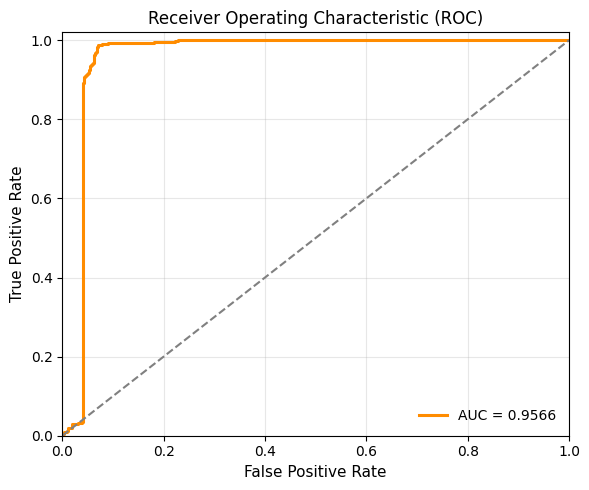

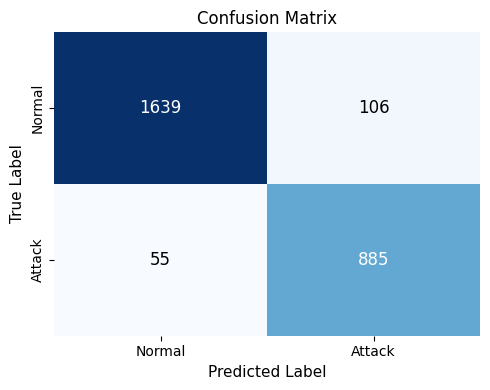

In [5]:
# ==========================================================
# ROC CURVE
# ==========================================================
fpr, tpr, thresholds = roc_curve(y_true, mse_attack)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2.2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=12)
plt.legend(loc="lower right", frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
if ENABLE_EVAL_SAVE:
    plt.savefig(
        EVAL_LOG_DIR / f"roc_curve_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}.png",
        dpi=600, bbox_inches="tight"
    )
plt.show()
plt.close()

# ==========================================================
# CONFUSION MATRIX (seaborn design, manual annot)
# ==========================================================
cm = confusion_matrix(y_true, y_pred_final, labels=[0, 1])
class_names = ['Normal', 'Attack']

plt.figure(figsize=(5, 4))
ax = sns.heatmap(
    cm, cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False
)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j + 0.5, i + 0.5, f"{cm[i, j]:d}",
            ha="center", va="center",
            fontsize=12,
            color="white" if cm[i, j] > thresh else "black"
        )

ax.set_ylim(cm.shape[0], 0)
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
plt.title('Confusion Matrix', fontsize=12)
plt.tight_layout()
if ENABLE_EVAL_SAVE:
    plt.savefig(
        EVAL_LOG_DIR / f"confusion_matrix_HS{HIDDEN_SIZE}_IW{SEQUENCE_LENGTH}.png",
        dpi=600, bbox_inches="tight"
    )

plt.show()
plt.close()


In [6]:
# ==========================================================
# THRESHOLD SWEEP
# ==========================================================
if USE_PERCENTILE_THRESHOLD:
    print("\n=== Threshold Sweep (for analysis) ===")

    sweep_f = None
    if ENABLE_EVAL_SAVE:
        sweep_path = EVAL_LOG_DIR / (
            f"threshold_sweep_"
            f"HS{HIDDEN_SIZE}_SL{SEQUENCE_LENGTH}.txt"
        )
        sweep_f = open(sweep_path, "w", encoding="utf-8")
        sweep_f.write("Threshold Sweep (analysis)\n")
        sweep_f.write("percentile | threshold | F1 | Precision | Recall | TN | FP | FN | TP\n")

    percentiles = [
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
        91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5
    ]

    for p in percentiles:
        thr = np.percentile(mse_calib, p)
        y_pred_sweep = (mse_attack > thr).astype(int)

        tn, fp, fn, tp = confusion_matrix(
            y_true, y_pred_sweep, labels=[0, 1]
        ).ravel()

        f1 = f1_score(y_true, y_pred_sweep)
        prec = precision_score(y_true, y_pred_sweep, zero_division=0)
        rec = recall_score(y_true, y_pred_sweep, zero_division=0)

        line = (
            f"{p:>5.1f}% | thr={thr:.8f} | "
            f"F1={f1:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | "
            f"TN={tn} | FP={fp} | FN={fn} | TP={tp}"
        )

        print(line)
        if sweep_f is not None:
            sweep_f.write(line + "\n")

    if sweep_f is not None:
        sweep_f.close()



=== Threshold Sweep (for analysis) ===
 70.0% | thr=0.01716434 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 71.0% | thr=0.01772305 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 72.0% | thr=0.01829074 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 73.0% | thr=0.01888472 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 74.0% | thr=0.01948120 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 75.0% | thr=0.02004542 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 76.0% | thr=0.02065689 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 77.0% | thr=0.02127314 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 78.0% | thr=0.02190605 | F1=0.519 | Prec=0.350 | Rec=1.000 | TN=0 | FP=1745 | FN=0 | TP=940
 79.0% | thr=0.02254085 | F1=0.519 | Prec=0.351 | Rec=1.000 | TN=5 | FP=1740 | FN=0 | TP=940
 80.0% | thr=0.02322527 | F1=0

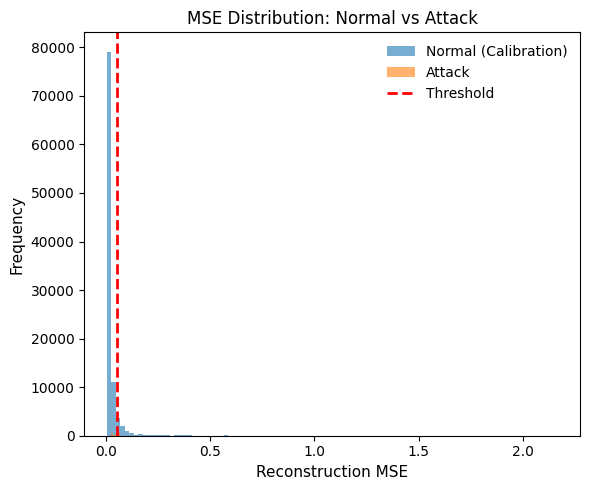

In [8]:
# ==========================================================
# MSE DISTRIBUTION (Normal vs Attack)
# ==========================================================
plt.figure(figsize=(6, 5))

plt.hist(mse_calib, bins=100, alpha=0.6, label="Normal (Calibration)")
plt.hist(mse_attack, bins=100, alpha=0.6, label="Attack")
plt.axvline(
    pred_threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Threshold"
)

plt.xlabel("Reconstruction MSE", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.title("MSE Distribution: Normal vs Attack", fontsize=12)
plt.legend(frameon=False)
plt.tight_layout()

if ENABLE_EVAL_SAVE:
    plt.savefig(
        EVAL_LOG_DIR / f"mse_distribution_HS{HIDDEN_SIZE}_SL{SEQUENCE_LENGTH}.png",
        dpi=600,
        bbox_inches="tight"
    )

plt.show()
plt.close()
